In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load and Pre-Process the Data

In [2]:
df = pd.read_csv('../data/founder_V0.3_founder.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '_')
df.columns 

Index(['Full_Name', 'Primary_Job_Title', 'Bio', 'Gender',
       'Number_of_News_Articles', 'Number_of_Founded_Organizations',
       'Number_of_Portfolio_Companies', 'Number_of_Investments_x',
       'Number_of_Partner_Investments', 'Number_of_Lead_Investments_x',
       'Number_of_Exits_x', 'Number_of_Events_x', 'Categories',
       'Headquarters_Location_', 'Operating_Status', 'Founded_Date',
       'Closed_Date', 'Company_Type', 'Number_of_Founders', 'Success',
       'Founder'],
      dtype='object')

In [4]:
df.shape

(18361, 21)

# Normalization

In [5]:
df['Number_of_News_Articles'] = df['Number_of_News_Articles']/df['Number_of_News_Articles'].max()

In [6]:
df['Number_of_Founded_Organizations'] = df['Number_of_Founded_Organizations']/df['Number_of_Founded_Organizations'].max()

In [7]:
df['Number_of_Portfolio_Companies'] = df['Number_of_Portfolio_Companies']/df['Number_of_Portfolio_Companies'].max()

In [8]:
df['Number_of_Investments_x'] = df['Number_of_Investments_x'] / df['Number_of_Investments_x'].max()

In [9]:
df['Number_of_Partner_Investments'] = df['Number_of_Partner_Investments'] /df['Number_of_Partner_Investments'].max()

In [10]:
df['Number_of_Lead_Investments_x'] = df['Number_of_Lead_Investments_x']/ df['Number_of_Lead_Investments_x'].max()

In [11]:
df['Number_of_Exits_x'] = df['Number_of_Exits_x'] / df['Number_of_Exits_x'].max()

In [12]:
df['Number_of_Events_x'] = df['Number_of_Events_x']/ df['Number_of_Events_x'].max()

# OHE Headquarters & Clean the Categories Column

### OHE Headqurters

In [13]:
country_Dummies = pd.get_dummies(df['Headquarters_Location_'])
df = pd.concat([df, country_Dummies], axis = 1)
df.shape


(18361, 163)

### A Few Helpful Functions

In [14]:
def get_unique_vals(column_name):
    unique_arr = []
    for val in df[column_name].values:
        arr = val.split(',')
        for category in arr:
            if category not in unique_arr:
                unique_arr.append(category.strip())
    return unique_arr

In [15]:
def get_all_vals(column_name):
    categories_arr = []
    for val in df[column_name].values:
        arr = val.split(',')
        categories_arr.append(arr[0].strip())
    return categories_arr


### Clean the Category Column
#### 1. Create Needed DataFrames

In [16]:
category_df = pd.Series(get_all_vals('Categories')) # all categories
counts_df =  pd.Series(pd.Series(get_all_vals('Categories')).value_counts()) # category counts
counts_df = pd.DataFrame(counts_df)
counts_df = counts_df.head(10)
counts_df

,0
Software,818
Health Care,532
Mobile,467
E-Commerce,400
Analytics,394
Internet,384
Enterprise Software,352
SaaS,308
0,306
Apps,288


### 2. Take top 10 Categories, Test if they're in each row, and convert the end values to 0/1

In [17]:
for cat in counts_df.index:
    category_bool = df["Categories"].apply(lambda x: cat in x)
    df[cat] = category_bool*1 # convert to True/False
  

# Next, make final changes and create **_clean_df_**

In [18]:
df['Gender'].value_counts() # 131 people responded 2
index_names = df[df["Gender"] == 2].index
df.drop(index_names, inplace=True)

In [19]:
df_filter_date = df[df['Founded_Date'] >= 1995]
df_filter_date.shape

(17900, 172)

In [20]:
clean_df = pd.DataFrame(df_filter_date)
clean_df.head(5)

,Full_Name,Primary_Job_Title,Bio,Gender,Number_of_News_Articles,Number_of_Founded_Organizations,Number_of_Portfolio_Companies,Number_of_Investments_x,Number_of_Partner_Investments,Number_of_Lead_Investments_x,...,United Kingdom,Software,Health Care,Mobile,E-Commerce,Analytics,Internet,Enterprise Software,SaaS,Apps
0,Elon Musk,"Chairman, Product Architect & CEO",Elon co-founded Tesla and continues to oversee...,1,0.734069,0.538462,0.112245,0.187500,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,JB Straubel,Co-Founder and CTO,The story of JB Straubel's career started at a...,1,0.005082,0.153846,0.010204,0.008929,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Mark Zuckerberg,Founder & CEO,Mark Zuckerberg is the founder and CEO of Face...,1,1.000000,0.769231,0.061224,0.062500,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Ross Mason,Founder and VP of Product Strategy,"Created the Mule Project, Founded MuleSoft, go...",1,0.006505,0.076923,0.061224,0.062500,0.0,0.0,...,0,1,0,0,0,0,0,1,0,1
4,Rahul Gandhi,Co-Founder & SVP of Finance Operations,Rahul is a Co-founder & Senior Vice President ...,1,0.043754,0.076923,0.000000,0.000000,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0


In [21]:
X = clean_df.drop(['Primary_Job_Title', 'Operating_Status', 'Company_Type', 'Success', 'Full_Name', 'Bio', 'Categories', 'Headquarters_Location_', 'Founder', 'Closed_Date', '0'], axis = 1)
y = clean_df['Success'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1234)
X.shape


(17900, 161)

# XGBoost

In [22]:
xgb_classifier = xgb.XGBClassifier(n_estimators= 1000, objective='binary:logistic', booster='gbtree', learning_rate=.3, colsample_bytree=.3, reg_alpha= .3, random_state = 1234)
xgb_classifier.fit(x_train, y_train)
xgb_y_pred = xgb_classifier.predict(x_test)

xgb_train_score = round(xgb_classifier.score(x_train, y_train)*100, 3)
xgb_test_score = round(xgb_classifier.score(x_test, y_test)*100, 3)

print("Train Accuracy: " + str(xgb_train_score))
print("Test Accuracy: " + str(xgb_test_score))


Train Accuracy: 89.644
Test Accuracy: 78.659


In [23]:
%%capture
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [50, 30]
plt.savefig("feature-importance.png") #easier to inspect as image

In [24]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print("RMSE: " + str(rmse))
print("MSE: " + str(mean_squared_error(y_test, xgb_y_pred)))

RMSE: 0.4619608438266714
MSE: 0.21340782122905028


# KNearestNeighbors

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 10, algorithm= 'auto', n_jobs=-1)

knn.fit(x_train, y_train)

knn_y_pred = knn.predict(x_test)

knn_train_score = round(knn.score(x_train, y_train)*100, 2)
knn_test_score = round(knn.score(x_test, y_test)*100, 2)

print(knn_train_score)
print(knn_test_score)


79.34
76.09


In [26]:
from sklearn.model_selection import cross_val_score 
k_neighbor = list(range(1, 24, 2))

cross_val_scores = []

for k in k_neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'accuracy')
    cross_val_scores.append(scores.mean())
print(cross_val_scores)

[0.7785614525139664, 0.7578212290502793, 0.7535614525139664, 0.7553770949720671, 0.7557960893854749, 0.7499301675977654, 0.7524441340782123, 0.7511871508379888, 0.752304469273743, 0.7502094972067039, 0.750977653631285, 0.7522346368715085]


In [27]:
print(max(cross_val_scores))

0.7785614525139664


In [28]:
misclassification_error = [1 - score for score in cross_val_scores]

best_k = k_neighbor[misclassification_error.index(min(misclassification_error))]
print("Best value for n_neighbors: " + str(best_k))

Best value for n_neighbors: 1


In [29]:
%%capture
plt.plot(k_neighbor, misclassification_error)
plt.xlabel("Number of Neighbors")
plt.ylabel("Misclassification Error")
plt.rcParams['figure.figsize'] = [5, 5]
plt.savefig('knn-misclassification.png')

# Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(n_estimators=int(np.sqrt(len(X.columns))), n_jobs=15, random_state= 1234)

rf_classification.fit(x_train, y_train)

rf_y_pred = rf_classification.predict(x_test)

rf_score_TEST = round(rf_classification.score(x_test, y_test)*100, 2)
rf_score_TRAIN = round(rf_classification.score(x_train, y_train)*100, 2)

print("Score on Training Data: " + str(rf_score_TRAIN))
print("Score on Testing Data: " + str(rf_score_TEST))


Score on Training Data: 96.82
Score on Testing Data: 79.27


# Gaussian Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(x_train, y_train)

gnb_y_pred = gnb_clf.predict(x_test)

gnb_score_TRAIN = round(gnb_clf.score(x_train, y_train)*100, 2)
gnb_score_TEST = round(gnb_clf.score(x_test, y_test)*100, 2)

print("{} Score on Training Data: ".format(str(gnb_clf.__class__.__name__)) + str(gnb_score_TRAIN))
print("{} Score on Testing Data: ".format(str(gnb_clf.__class__.__name__)) + str(gnb_score_TEST))

GaussianNB Score on Training Data: 41.89
GaussianNB Score on Testing Data: 41.84


# Decision Tree Classifier

### Grid Search

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

def decisionTreeGridSearch():
    scaler = StandardScaler()
    dt_clf = DecisionTreeClassifier()

    pipe = Pipeline(
        steps=[
            ('scaler', scaler),
            ('decisiontree', dt_clf)
        ]
    )

    criterion = ['gini', 'entropy']
    max_depth = [2, 4, 6, 8, 10, 12]
    splitter = ['best', 'random']
    max_features = ['auto', 'sqrt', 'log2']


    params = dict(
        decisiontree__criterion = criterion,
        decisiontree__max_depth = max_depth,
        decisiontree__splitter = splitter,
        decisiontree__max_features = max_features
    )

    clf = GridSearchCV(pipe, params)

    clf.fit(x_train, y_train)
    return clf.best_estimator_.get_params()['decisiontree__criterion'], clf.best_estimator_.get_params()['decisiontree__max_depth'], clf.best_estimator_.get_params()['decisiontree__splitter'], clf.best_estimator_.get_params()['decisiontree__max_features']

paramsToUse = decisionTreeGridSearch()



### Use Best Params in Model

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_features=str(paramsToUse[3]), criterion= str(paramsToUse[0]), splitter= str(paramsToUse[2]), max_depth= int(paramsToUse[1]))

dt_clf.fit(x_train, y_train)

dt_y_pred = dt_clf.predict(x_test)

dt_score_TRAIN = round(dt_clf.score(x_train, y_train)*100, 2)
dt_score_TEST = round(dt_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TRAIN))
print("{} TESTING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TEST))


DecisionTreeClassifier TRAINING Score: 70.22
DecisionTreeClassifier TESTING Score: 70.36


In [34]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_features='log2', random_state=1234, criterion="entropy", splitter="best")

dt_clf.fit(x_train, y_train)

dt_y_pred = dt_clf.predict(x_test)

dt_score_TRAIN = round(dt_clf.score(x_train, y_train)*100, 2)
dt_score_TEST = round(dt_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TRAIN))
print("{} TESTING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TEST))


DecisionTreeClassifier TRAINING Score: 97.48
DecisionTreeClassifier TESTING Score: 74.16


# Log Regression

In [35]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()

log_clf.fit(x_train, y_train)

log_y_pred = log_clf.predict(x_test)

log_score_TRAIN = round(log_clf.score(x_train, y_train)*100, 2)
log_score_TEST = round(log_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TRAIN))
print("{} TESTING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TEST))


LogisticRegression TRAINING Score: 63.23
LogisticRegression TESTING Score: 64.27


/Users/danielmurphy/opt/miniconda3/envs/classification-model/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Ensemble Model

In [36]:
from sklearn.ensemble import VotingClassifier

rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier()
# dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators= [('rf', rf_clf), ('knn', knn_clf), ('xgb', xgb_clf)],
    voting='soft' # more weight to highly confident votes
)

voting_clf.fit(x_train, y_train)
voting_y_pred = voting_clf.predict(x_test)

voting_train_score = round(voting_clf.score(x_train, y_train)*100, 2)
voting_test_score = round(voting_clf.score(x_test, y_test)*100, 2)

print(voting_train_score)
print(voting_test_score)
print("\n")

for classifier in (rf_clf, knn_clf, xgb_clf, voting_clf):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    print(classifier.__class__.__name__)
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("MSE: " + str(mean_squared_error(y_test, y_pred)))
    print('\n\n')

# RMSE: Square root of the variance of the residuals
# MSE: Variance of the residuals

92.06
80.31


RandomForestClassifier
Accuracy: 0.8011173184357542
RMSE: 0.44596264592928164
MSE: 0.19888268156424582



KNeighborsClassifier
Accuracy: 0.7622905027932961
RMSE: 0.4875546094610366
MSE: 0.23770949720670392



XGBClassifier
Accuracy: 0.7821229050279329
RMSE: 0.46677306581685607
MSE: 0.21787709497206703



VotingClassifier
Accuracy: 0.8008379888268157
RMSE: 0.44627571205834665
MSE: 0.19916201117318436





# Confusion Matrix & AUC

In [37]:
from sklearn.metrics import confusion_matrix

i = 0
model_predictions = [xgb_y_pred, knn_y_pred, log_y_pred, rf_y_pred, gnb_y_pred, dt_y_pred]
for pred in model_predictions:
    print("Confusion Matrix: {}".format(model_predictions[i].__class__.__name__) + " " + str(i) + str('\n') + str(confusion_matrix(y_test, pred)))
    i += 1



Confusion Matrix: ndarray 0
[[1856  324]
 [ 440  960]]
Confusion Matrix: ndarray 1
[[1877  303]
 [ 553  847]]
Confusion Matrix: ndarray 2
[[1937  243]
 [1036  364]]
Confusion Matrix: ndarray 3
[[1883  297]
 [ 445  955]]
Confusion Matrix: ndarray 4
[[ 124 2056]
 [  26 1374]]
Confusion Matrix: ndarray 5
[[1755  425]
 [ 500  900]]


In [38]:
model_predictions = [xgb_y_pred, knn_y_pred, log_y_pred, rf_y_pred, gnb_y_pred, dt_y_pred]
for pred in model_predictions:
    print(pd.crosstab(y_test, pred, rownames=["True"], colnames=["Predicted"]))


Predicted     0    1
True                
0          1856  324
1           440  960
Predicted     0    1
True                
0          1877  303
1           553  847
Predicted     0    1
True                
0          1937  243
1          1036  364
Predicted     0    1
True                
0          1883  297
1           445  955
Predicted    0     1
True                
0          124  2056
1           26  1374
Predicted     0    1
True                
0          1755  425
1           500  900


Text(0.5, 1, 'Rand Forest Confusion Matrix')

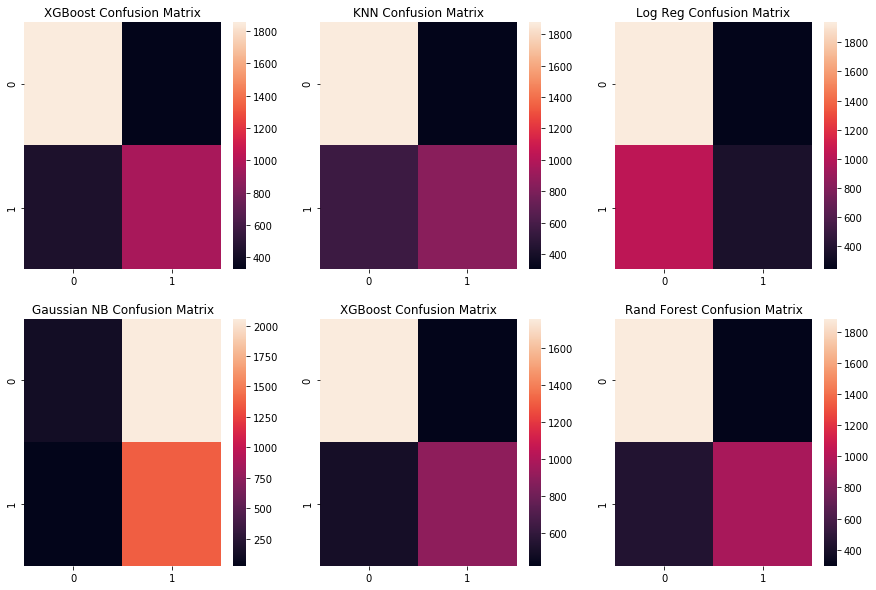

In [39]:
import seaborn as sns

plt.rcParams['figure.figsize'] = 15, 10

figure, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3)
plot1 = sns.heatmap(confusion_matrix(y_test, xgb_y_pred), ax = ax1)
plot1.set_title('XGBoost Confusion Matrix')

plot2 = sns.heatmap(confusion_matrix(y_test, knn_y_pred), ax = ax2)
plot2.set_title('KNN Confusion Matrix')

plot3 = sns.heatmap(confusion_matrix(y_test, log_y_pred), ax = ax3)
plot3.set_title('Log Reg Confusion Matrix')

plot4 = sns.heatmap(confusion_matrix(y_test, gnb_y_pred), ax = ax4)
plot4.set_title('Gaussian NB Confusion Matrix')

plot5 = sns.heatmap(confusion_matrix(y_test, dt_y_pred), ax = ax5)
plot5.set_title('XGBoost Confusion Matrix')

plot6 = sns.heatmap(confusion_matrix(y_test, rf_y_pred), ax = ax6)
plot6.set_title('Rand Forest Confusion Matrix')

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

print("AUC: \n{}".format(roc_auc_score(y_test, voting_y_pred))) # 1.00 would be 100% correct model, 0.0 would be 100% wrong model
print("\n")
print("Receiver Operating Characteristic: \n{}".format(roc_curve(y_test, voting_y_pred)))

AUC: 
0.7873165137614678


Receiver Operating Characteristic: 
(array([0.        , 0.14036697, 1.        ]), array([0.   , 0.715, 1.   ]), array([2, 1, 0]))


False Positive Rate: [0.         0.14036697 1.        ]
True Positive Rate: [0.    0.715 1.   ]


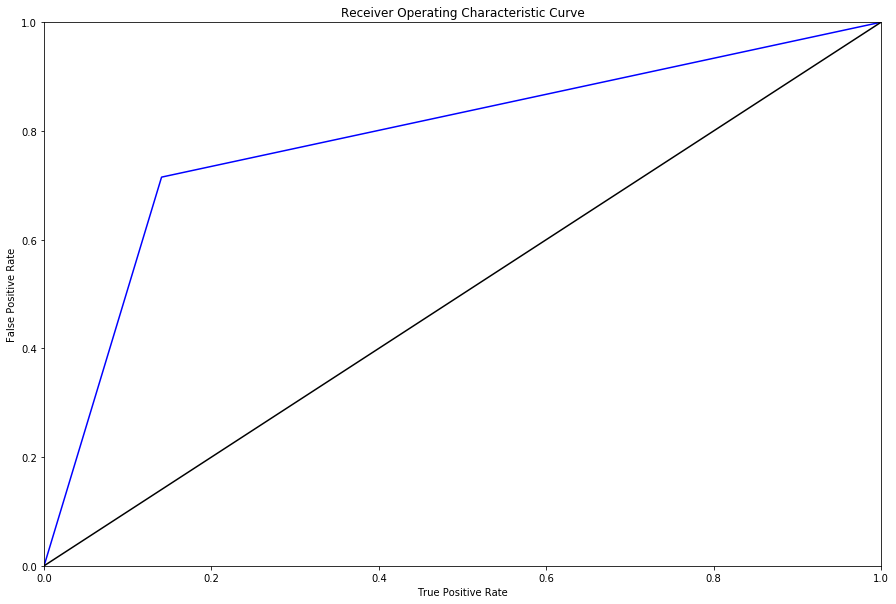

In [41]:
fpr, tpr, threshold = roc_curve(y_test, voting_y_pred)

print("False Positive Rate: {}".format(fpr))
print("True Positive Rate: {}".format(tpr))

roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots(ncols =1)


plt.rcParams['figure.figsize'] = 10, 8
plt.title("Receiver Operating Characteristic Curve")
plt.plot(fpr, tpr, 'b')
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.xlim([0,1])
plt.ylim([0,1])

x = np.linspace(*ax.get_xlim()) # 45 degree line to measure ROC...
plt.plot(x, x, 'black')
# The closer the ROC to the 45 degree line, the less accurate 



In [42]:
print(precision_score(y_test, voting_y_pred))

0.7658760520275439
